In [1]:
#드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt

In [3]:
dangjin =  pd.read_csv('/content/drive/MyDrive/Colab Notebooks/전주시 데이터분석/data/RF_cloud.csv')
dangjin_obs=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/전주시 데이터분석/당진/dangjin_obs_data.csv')
energy=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/전주시 데이터분석/data/energy.csv')
site_info=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/전주시 데이터분석/data/site_info.csv')

dangjin_obs.rename(columns={'일시':'Time'},inplace=True)
dangjin['Time'] = dangjin_obs['Time']
dangjin = dangjin.dropna(axis=0).reset_index(drop=True)

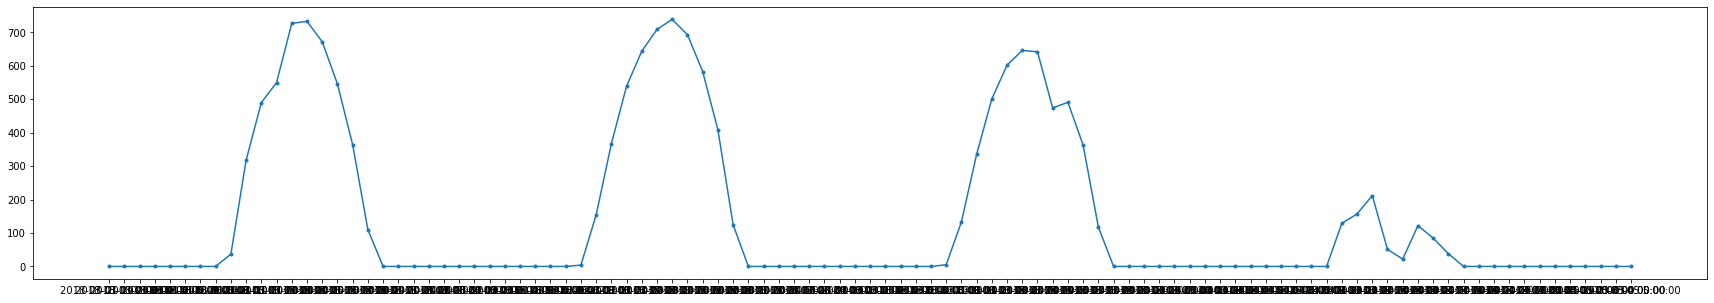

In [4]:
plt.figure(figsize=(30,5))
plt.plot(energy.loc[:100,'time'], energy.loc[:100,'dangjin'], '.-')

In [5]:
site_info 

,Id,Capacity,Address,InstallationAngle,IncidentAngle,Latitude,Longitude
0,당진수상태양광,1.0,충남 당진시 석문면 교로길 30,30.0,30.0,37.050753,126.510299
1,당진자재창고태양광,0.7,충남 당진시 석문면 교로길 30,30.0,30.0,37.050753,126.510299
2,당진태양광,1.0,충남 당진시 석문면 교로길 30,30.0,30.0,37.050753,126.510299
3,울산태양광,0.5,울산광역시 남구 용잠로 623,20.0,20.0,35.477651,129.380778


In [6]:
energy.dangjin.isna().sum()

0

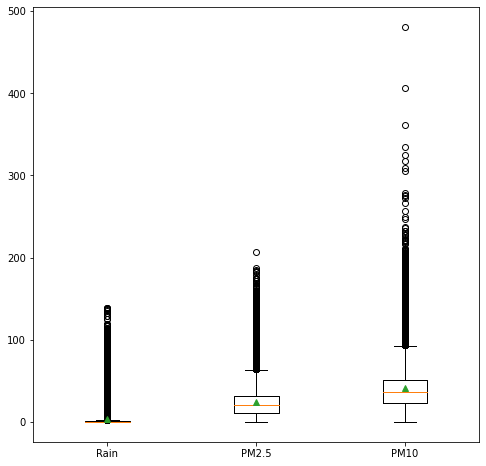

In [7]:
import seaborn as sns
plt.figure(figsize=(8,8))
data = [ dangjin['Rain'],dangjin['PM2.5']	,dangjin['PM10']]
plt.boxplot(data, labels=['Rain','PM2.5',	'PM10'], showmeans=True)
plt.show()
#근데 단위 다른데 이렇게 그려도 되나?? 된당
#dangjin['Rain']
#dangjin['Cloud'],dangjin['Temperature'],dangjin['WindSpeed']	,dangjin['Humidity'],dangjin['solar'],dangjin['Cloud'],	dangjin['sunTime'],dangjin['so2']	,dangjin['ozone']	,dangjin['no2'],는 이상치 없음

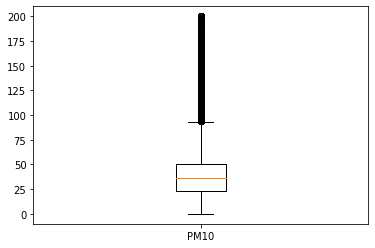

In [8]:
#미세먼지 200이상 --> 200으로 바꾸기
# 
dangjin[dangjin['PM10']>200] = 200
plt.boxplot(dangjin['PM10'], labels=['PM10'])
plt.show()

dangjin[dangjin['PM2.5']>180] = 180


이상치 처리 :
IQR 방식은 75% percentile + 1.5 * IQR 이상이거나 25 percentile - 1.5 * IQR 이하인 경우 극단치로 처리하는 방식이다. 이해하기 쉽고 적용하기 쉬운 편이지만, 경우에 따라 너무 많은 사례들이 극단치로 고려되는 경우가 있다.



In [9]:
#당진태양광
dangjin['energy'] = energy.dangjin
dangjin_notime=dangjin[dangjin.columns.difference(['Time'])]
dangjin_notime# = dangjin_notime[['Temperature','solar','Humidity','energy']]
#dangjin_notime

,Cloud,Humidity,PM10,PM2.5,Rain,Temperature,WindSpeed,energy,no2,ozone,so2,solar,sunTime
0,8.181862,96.0,10.0,7.000000,1.800000,3.1,3.6,0,0.010000,0.029000,0.002000,0.0,0.0
1,6.103821,97.0,9.0,4.000000,1.792298,2.8,0.7,0,0.011000,0.029000,0.002000,0.0,0.0
2,8.050075,95.0,1.0,15.813530,1.778744,2.6,3.2,0,0.013000,0.027000,0.003000,0.0,0.0
3,7.700740,97.0,1.0,17.699579,1.759338,2.0,1.9,0,0.011000,0.025000,0.002000,0.0,0.0
4,7.804446,97.0,1.0,18.325597,1.734080,2.2,2.1,0,0.009000,0.028000,0.002000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25302,0.000000,82.0,85.0,41.000000,0.064975,-0.3,0.8,0,0.025427,0.015715,0.003329,0.0,0.0
25303,0.000000,84.0,177.0,45.000000,0.051168,-1.6,0.0,0,0.019436,0.026356,0.003961,0.0,0.0
25304,0.000000,86.0,140.0,45.000000,0.035736,-2.0,0.1,0,0.020601,0.026718,0.004118,0.0,0.0
25305,1.000000,88.0,83.0,31.233271,0.018680,-2.4,0.9,88,0.019320,0.025104,0.003591,0.0,0.0


In [10]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits =10, shuffle=True, random_state=10)

In [11]:
from sklearn.model_selection import train_test_split
 
x = dangjin_notime[dangjin_notime.columns.difference(['energy'])] 
y = dangjin_notime['energy']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))
y_train = y_train.astype('float32')
#x_train = x_train.astype('float32').round(3)


17714
7593
17714
7593


In [12]:
#    매개변수 튜닝(정규화) 없이도 잘 작동
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics    
from sklearn.metrics import classification_report 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

forest = RandomForestClassifier(n_estimators=150, random_state=10,max_depth=16)
#,max_depth=16,  min_samples_leaf= 2, min_samples_split= 2
forest.fit(x_train, y_train)
y_pred = forest.predict(x_test)
print(y_pred)
print(y_test)

print('정확도 :', metrics.accuracy_score(y_test, y_pred)) 
print(mean_squared_error(y_test, y_pred))


[0. 0. 0. ... 0. 0. 0.]
21904     8
24668     0
11858     0
3751     52
2737      0
         ..
8981      0
2815      0
12704    15
25227     0
238       0
Name: energy, Length: 7593, dtype: int64
정확도 : 0.5461609377057817
65898.87132885553


In [13]:
# from sklearn.model_selection import GridSearchCV

# params = { 'n_estimators' : [10,100],
#            'max_depth' : [16,32,64],
#            'min_samples_leaf' : [1,2,4],
#            'min_samples_split' : [1,2]
#             }

# # RandomForestClassifier 객체 생성 후 GridSearchCV 수행
# rf_clf = RandomForestClassifier(random_state = 10, n_jobs = -1)
# grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
# grid_cv.fit(x_train, y_train)

# print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
# print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

# # 최적 하이퍼 파라미터:  {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
# # 최고 예측 정확도: 0.3623 


In [14]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=100, random_state=10,n_jobs=-1)
forest.fit(x_train, y_train)
print(forest.score(x_train, y_train))
print(forest.score(x_test, y_test))

# ##########모델 예측
#x_temp = df_nacloud[df_nacloud.columns.difference(['Cloud'])] #na인것만 다시 가져올것

y_predict = forest.predict( x_test )

# print("="*100)
# pd.DataFrame(y_predict).value_counts()
#print(mean_squared_error(y_test, y_predict))

#print('정확도 :', metrics.accuracy_score(y_test, y_predict))
print(mean_squared_error(y_test, y_predict))

0.908295315780485
0.3569615780698161
31471.422372472916


In [15]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error

def rmsle(predict, actual):
  predict = np.array(predict)
  actual = np.array(actual)

  log_predict = np.log(predict+1)
  log_actual = np.log(actual+1)

  difference = log_predict - log_actual
  difference=np.square(difference)
  
  mean_difference = difference.mean()
  score = np.sqrt(mean_difference)

  return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

RMSLE = np.sqrt(mean_squared_log_error(y_test, y_predict))
RMSLE
#RMSLE는 아웃라이어에 강건하다고 말할 수 있습니다. 앗 

3.3523943759722425

In [16]:
# %time score = cross_val_score(forest , x_train, y_train, cv=k_fold, scoring=rmsle_scorer)
# score = score.mean()
# #0에 근접할 수록 좋다
# print("Score = {0:.5f}".format(score))


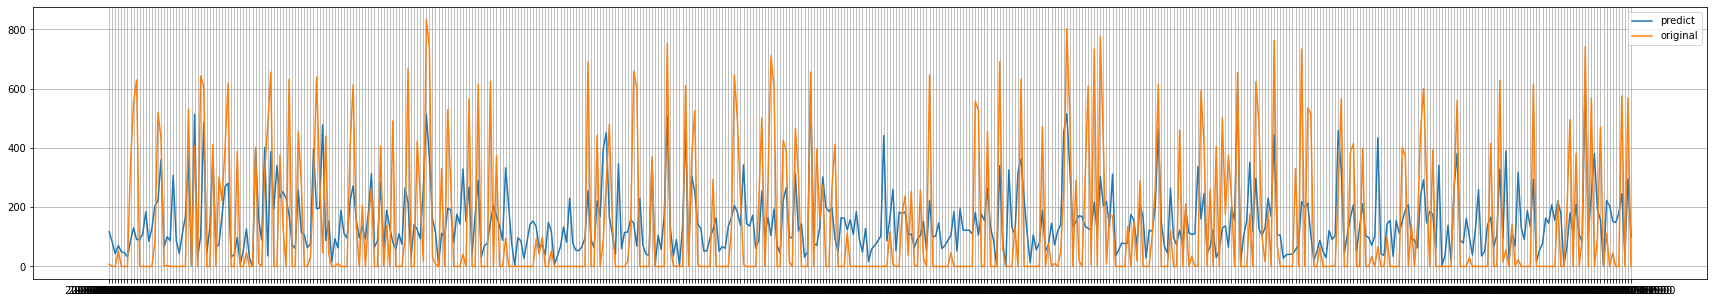

In [17]:
plt.figure(figsize=(30,5))
plt.plot(dangjin.Time[:500], y_predict[:500])
plt.plot(dangjin.Time[:500], y_test[:500])
plt.legend(['predict','original'])
plt.grid()

특성 중요도 : 
[0.08667127 0.09083208 0.0845552  0.07953571 0.0807074  0.14945484
 0.07495961 0.07321147 0.10108702 0.05596438 0.10989936 0.01312166]


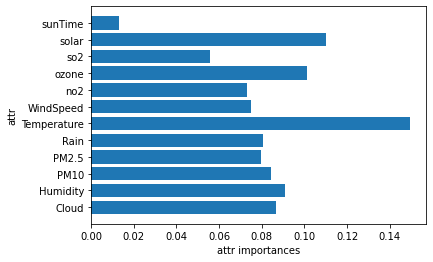

In [18]:
print("특성 중요도 : \n{}".format(forest.feature_importances_))
feature_names = x_train.columns.tolist()

def plot_feature_importances(model):

    n_features = x_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_)

    plt.yticks(np.arange(n_features),feature_names)

    plt.xlabel("attr importances")

    plt.ylabel("attr")

plt.show()
plot_feature_importances(forest)